In [149]:
import numpy as np
import keras
import pandas as pd
from keras.src.layers import LSTM, Dense, InputLayer, Dropout
from keras.src.utils import timeseries_dataset_from_array
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = pd.read_csv('pvtest.csv')

df = df[['Edaily', 'Dci', 'Dcp', 'Dcu', 'Temp1', 'Time', 'Dcp']]
df['Time'] = pd.to_datetime(df['Time'], format='%d.%m.%y %H:%M')
df.set_index('Time', inplace=True)

print(df.head())



                     Edaily  Dci  Dcp  Dcu  Temp1  Dcp
Time                                                  
2021-01-20 07:45:00     0.0  0.0    0    0    0.0    0
2021-01-20 07:50:00     0.0  0.0    0    0    0.0    0
2021-01-20 07:55:00     0.0  0.0    0    0    0.0    0
2021-01-20 08:00:00     0.0  0.0    0    0    0.0    0
2021-01-20 08:05:00     0.0  0.0    0    0    0.0    0


### b)

In [150]:
lookback = 36  # 60 / 5 * 3

n = len(df)

train_df = df[:int(n * 0.8)]
val_df   = df[int(n * 0.8):]


### c)

In [151]:
x_train = train_df[['Edaily', 'Dci', 'Dcp', 'Dcu', 'Temp1']]
y_train = train_df['Dcp']

x_val = val_df[['Edaily', 'Dci', 'Dcp', 'Dcu', 'Temp1']]
y_val = val_df['Dcp']

Xscaler = StandardScaler()
x_train_scaled = Xscaler.fit_transform(x_train)
x_val_scaled = Xscaler.transform(x_val)

Yscaler = StandardScaler()
y_train_scaled = Yscaler.fit_transform(y_train)
y_val_scaled = Yscaler.transform(y_val)

train_ds = timeseries_dataset_from_array(
    data=x_train_scaled,
    targets=y_train_scaled[lookback:],
    sequence_length=lookback,
    shuffle=False,
)

val_ds = timeseries_dataset_from_array(
    data=x_val_scaled,
    targets=y_val_scaled[lookback:],
    sequence_length=lookback,
    shuffle=False,
)

### d)

In [152]:
model = keras.Sequential()
#model.add(InputLayer(input_shape=x_train.shape))
model.add(LSTM(32, input_shape=(lookback, 6)))
model.add(Dropout(0.02))
model.add(Dense(20))
model.add(Dense(1))

model.compile(optimizer='adam', loss='huber', metrics=['mean_absolute_error'])

/home/jef/git/ML-3/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### e)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1904 - mean_absolute_error: 0.3973 - val_loss: 0.1556 - val_mean_absolute_error: 0.3479
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1100 - mean_absolute_error: 0.2589 - val_loss: 0.0995 - val_mean_absolute_error: 0.2522
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0792 - mean_absolute_error: 0.2054 - val_loss: 0.0647 - val_mean_absolute_error: 0.2042
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0616 - mean_absolute_error: 0.1787 - val_loss: 0.0460 - val_mean_absolute_error: 0.1698
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0489 - mean_absolute_error: 0.1582 - val_loss: 0.0393 - val_mean_absolute_error: 0.1512
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0415 - mean_absolute_error: 0.1449 - val_loss: 0.0352 - val_mean_absolute_error: 0.1406
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0380 - mean_absolute_error: 0.1392 - v

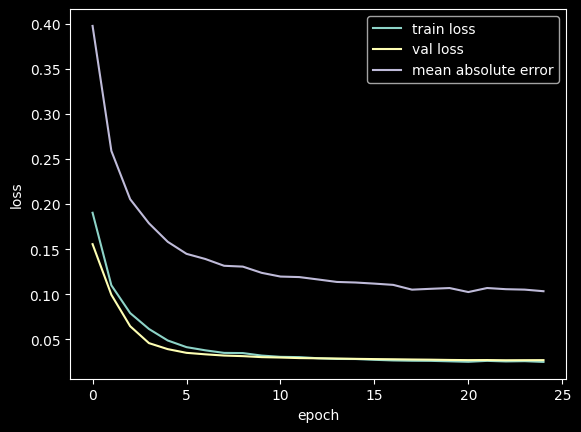

In [153]:
hist = model.fit(train_ds, validation_data=val_ds, epochs=100, batch_size=32, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.plot(hist.history['mean_absolute_error'], label='mean absolute error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


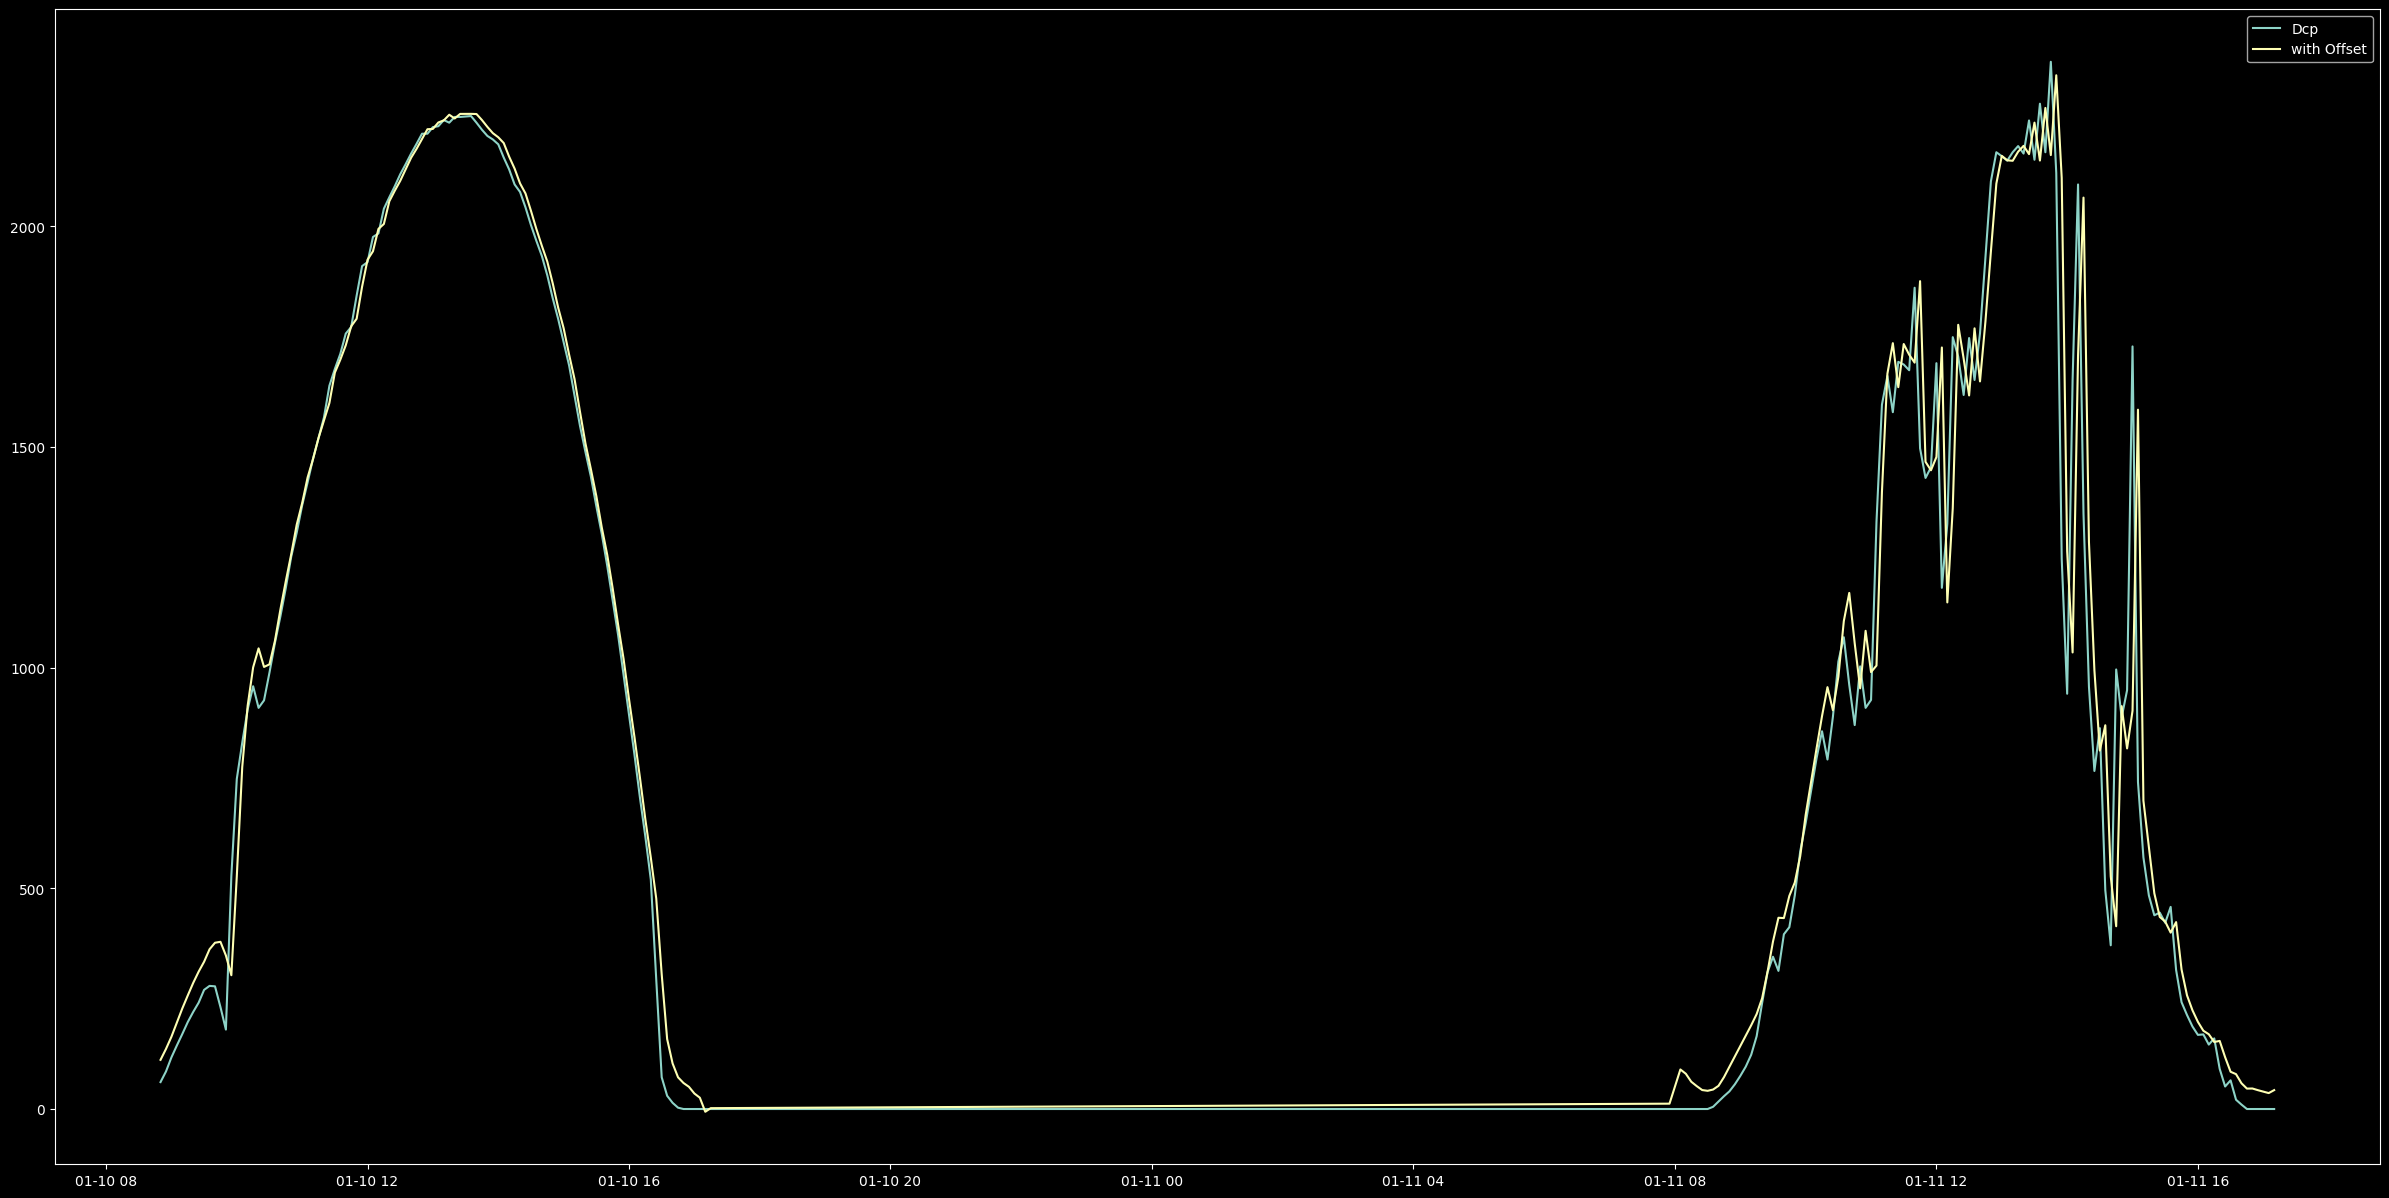

In [164]:
#demo = df[int(len(df)*.8)+1:int(len(df)*.9)]
df = df.sort_index()
#print(df.index.is_monotonic_increasing)
#print(y_val.head())
demo = df.loc['2021-01-9 15:00:00':'2021-01-12 06:00:00']

demo_X = demo[['Edaily', 'Dci', 'Dcp', 'Dcu', 'Temp1']]
demo_X_scaled = Xscaler.transform(demo_X)

X_windows = []
for i in range(len(demo_X_scaled) - lookback):
    X_windows.append(demo_X_scaled[i:i+lookback])
X_windows = np.array(X_windows)

demo_predicted_scaled = model.predict(X_windows)

#temp1 = np.array(demo_predicted_scaled).reshape(-1,1)
#temp2 = pd.Series(X, name="Predicted")

# Scaler hatte Series als input wäh
demo_predicted = Yscaler.inverse_transform(np.concat([demo_predicted_scaled, demo_predicted_scaled], axis=1))

demo_predicted_offset = demo_predicted+71

#print(demo.size)

timestamps = demo.index[lookback:]

plt.figure(figsize=(30,15))
plt.plot(timestamps, demo['Dcp'].values[lookback:][:,0:1],label='Dcp')
#plt.plot(timestamps, demo_predicted[:, 0:1],label='prediction')
plt.plot(timestamps, demo_predicted_offset[:, 0:1],label='with Offset')
plt.legend()
plt.show()